# devlog 2024-05-17

_Author: Sindhura Paruchuri and Tyler Coles_

Demonstrating several probability distributions which may be useful in developing bird and mosquito movement models.

In [1]:
from functools import partial

import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygris
from numpy.typing import NDArray

import epymorph.initializer as init
from epymorph.data import geo_library, ipm_library
from epymorph.engine.standard_sim import StandardSimulation
from epymorph.movement.parser import parse_movement_spec
from epymorph.simulation import SimDType, TimeFrame, sim_messaging
from epymorph.util import pairwise_haversine

## Weibull Distribution

The Weibull distribution is used in the source paper to model localized bird movement. Our first task is to correctly compute the value of the Weibull distribution.

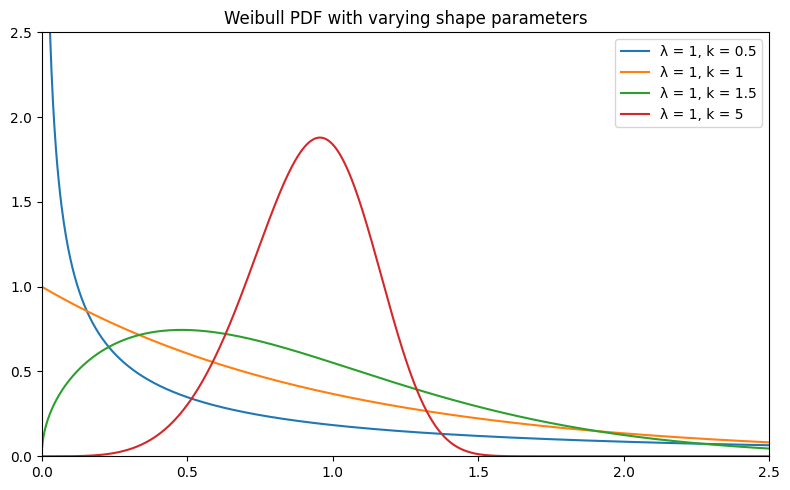

In [2]:
def weibull_distribution(x: NDArray[np.float64], scale: float, shape: float) -> NDArray[np.float64]:
    """
    Calculate the Weibull distribution probability density function for each value in `x`.
    `shape` and `scale` are parameters which alter the shape of the distribution,
    and each must be greater than zero.
    https://en.wikipedia.org/wiki/Weibull_distribution
    """
    if shape <= 0 or scale <= 0:
        raise ValueError("`shape` and `scale` must be greater than zero.")
    return ((shape / scale)
            * ((x / scale) ** (shape - 1))
            * (np.exp(-((x / scale) ** shape))))


# To demonstrate this function, we'll duplicate the PDF figure from the wikipedia article:
# https://en.wikipedia.org/wiki/Weibull_distribution


params_scale_shape = [
    (1, 0.5),
    (1, 1),
    (1, 1.5),
    (1, 5),
]

fig, ax = plt.subplots(figsize=(8,5))
x = np.linspace(0.001, 2.5, num=1000)
for scale, shape in params_scale_shape:
    y = weibull_distribution(x, scale, shape)
    ax.plot(x, y, label=f"λ = {scale}, k = {shape}")
ax.set_title("Weibull PDF with varying shape parameters")
ax.set_ylim(0, 2.5)
ax.set_xlim(0, 2.5)
ax.legend()
fig.tight_layout()
plt.show()

And now we can plot probability vs. distance using the parameters from the reference paper.

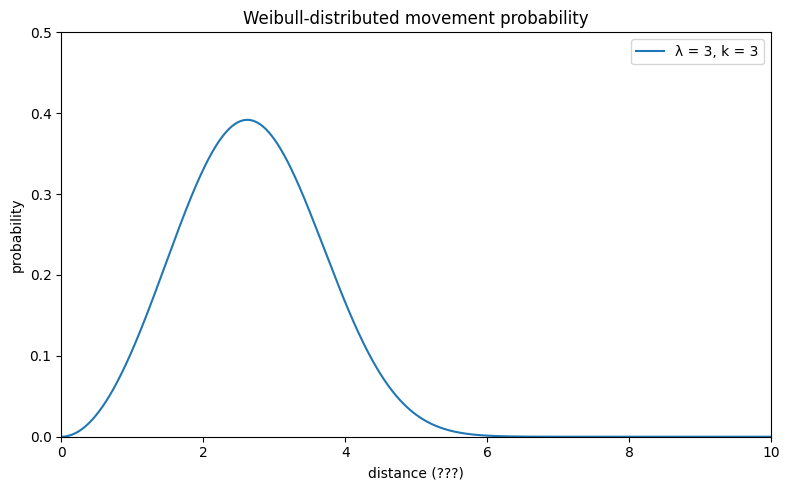

In [3]:
x = np.linspace(0.001, 10.0, num=1000)
y = weibull_distribution(x, shape=3, scale=3)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x, y, label=f"λ = 3, k = 3")
ax.set_title("Weibull-distributed movement probability")
ax.set_ylabel("probability")
ax.set_xlabel("distance (???)")
ax.set_ylim(0, 0.5)
ax.set_xlim(0, 10)
ax.legend()
fig.tight_layout()
plt.show()

Now we can put this to practice in a movement model, run an epymorph simulation, and inspect its results to prove that it behaves as expected.

For the sake of demonstrating only the movement model mechanics, we set up our simulation as follows:
- A geo which covers Maricopa County, AZ at the CBG level.
- A placeholder IPM (one compartment, no transitions).
- A movement model based using the Weibull-distributed probabilities to govern movement.
- We set all starting populations at zero except for one selected node.

This way the "prevalence" data during the simulation is simple to examine; it's entirely due to movement from the selected source node. This is of course a limited and artificial scenario, but crafted just so to demonstrate the operation of the movement model.

In [4]:
mm_spec = parse_movement_spec("""
[move-steps: per-day=2; duration=[1/3, 2/3]]

[predef: function=
def birds_predef():
    scale = 3
    shape = 3
    
    centroid = geo['centroid']
    distance = pairwise_haversine(centroid['longitude'], centroid['latitude'])
    
    weibull = ((shape / scale)
            * ((distance / scale) ** (shape - 1))
            * (np.exp(-((distance / scale) ** shape))))
    return {'prob': row_normalize(weibull)}
]

[mtype: days=all; leave=1; duration=0d; return=2; function=
def birds_local(t):
    n_movers = np.floor(geo['bird_population'] * 0.5).astype(SimDType)
    return np.multinomial(n_movers, predef['prob'])
]
""")

geo = geo_library['maricopa_cbg_2019']()

selected_geoid = '040130927211'
selected = np.where(geo['geoid'] == selected_geoid)[0][0]

distances = pairwise_haversine(geo['centroid']['longitude'], geo['centroid']['latitude'])

# Add bird population to geo.
birds = np.zeros(shape=geo.nodes, dtype=SimDType)
birds[selected] = 50_000
geo.values['bird_population'] = birds

sim = StandardSimulation(
    geo=geo,
    ipm=ipm_library['no'](),
    mm=mm_spec,
    params={},
    time_frame=TimeFrame.of("2023-01-01", 10),
    initializer=partial(init.explicit, initials=birds.reshape((geo.nodes, 1))),
    rng=lambda: np.random.default_rng(42),
)

with sim_messaging(sim):
    out = sim.run()

Running simulation (StandardSimulation):
• 2023-01-01 to 2023-01-11 (10 days)
• 2494 geo nodes
|####################| 100% 
Runtime: 9.456s


And to map it we have to merge our simulation results with geography from pygris.

In [5]:
visitors = out.prevalence[:, :, 0].mean(axis=0)
visitors[selected] = 0 # birds at home aren't visitors!

maricopa_gdf = pygris.block_groups(
    state="Arizona",
    county="Maricopa",
    year=2019,
    cache=True,
)

def get_coords(geoid: str) -> tuple[float, float]:
    row = maricopa_gdf[maricopa_gdf['GEOID'] == geoid].iloc[0]
    return float(row['INTPTLON']), float(row['INTPTLAT'])

selected_coords = get_coords(selected_geoid)

gdf = gp.GeoDataFrame(
    pd.merge(
        left=maricopa_gdf[['GEOID', 'COUNTYFP', 'geometry']],
        right=pd.DataFrame({
            'GEOID': geo['geoid'],
            # distances relative to the selected node
            'distance': distances[selected],
            # mean visiting birds over the simulation
            'visitors': visitors,
        }),
        on='GEOID',
        how='outer',
    )
)

Using FIPS code '04' for input 'Arizona'
Using FIPS code '013' for input 'Maricopa'


Now we can plot a map of Maricopa County with each CBG colorized by the average number of visitors over the simulation.

We expect to see a rough donut shape -- we can imagine standing the Weibull PDF curve vertically on the map, with zero at the source node, and rotating it around the unit circle. The height of the curve at each node's centroid is proportional to the expected value for that node.

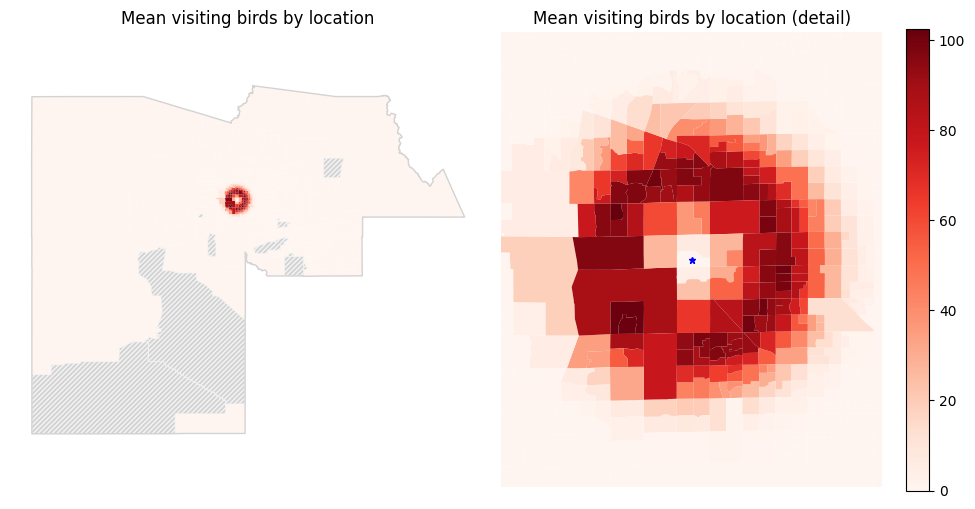

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].axis('off')
axs[0].set_title('Mean visiting birds by location')
gdf.plot(
    ax=axs[0],
    column='visitors',
    cmap='Reds',
    # legend=True,
    # NOTE: the geo we're using omits some CBGs, mostly because they have no human population.
    # That's not super relevant to birds, but we'll leave it as is because it doesn't impact our results in this case.
    # The "missing" CBGs are filled with hatching on this map.
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "whitesmoke",
        "hatch": "///////",
        "linewidth": 0.5,
        "label": "Missing values",
    },
)
# Draw county outline.
gdf.dissolve(by='COUNTYFP')\
    .plot(ax=axs[0], linewidth=1, edgecolor="lightgrey", facecolor="none")

axs[1].axis('off')
axs[1].set_title('Mean visiting birds by location (detail)')
gdf.plot(
    ax=axs[1],
    column='visitors',
    cmap='Reds',
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "whitesmoke",
        "hatch": "///////",
        "linewidth": 0.5,
        "label": "Missing values",
    },
)
# Zoom in.
(lon, lat) = selected_coords
axs[1].set_xlim(lon - 0.1, lon + 0.1)
axs[1].set_ylim(lat - 0.1, lat + 0.1)
# Mark the source node.
axs[1].plot(lon, lat, marker='*', color='blue', markersize=5)

fig.tight_layout()
fig.align_titles()
plt.show()

And if we take the average visitors to each node and plot that against distance from the source node, we would expect to see that average mirrors the Weibull distribution PDF curve plus some stochastic noise.

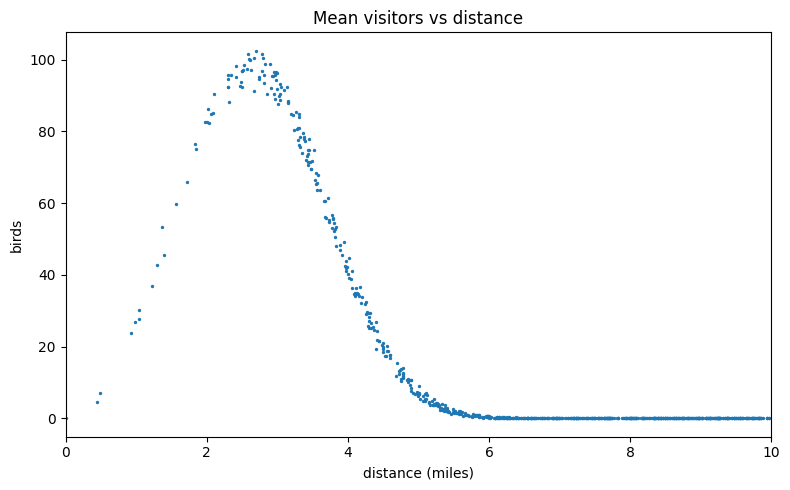

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(gdf['distance'], gdf['visitors'], s=2)
ax.set_title("Mean visitors vs distance")
ax.set_xlabel("distance (miles)")
ax.set_ylabel("birds")
ax.set_xlim(0, 10)
fig.tight_layout()
plt.show()